# Reading
The spyder has scraped the website, and stored the results in jobitems.json file
In this notebook this file is cleaned, processed and analyzed for valuable insigth into the job market.

In [46]:
import warnings
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [67]:
df_jobs_raw = pd.read_json('../jobitems.json')
df_jobs_raw.shape
df_jobs_raw.head()

,title,employer,town,tags,stress_tags,timestamp,affiliation,item_name,application_type,category1,category2,category3,category4,category5,category6,currency,item_brand,item_id,link,linktarget,list_id,list_index,list_name,location_id,price,prof_category,prof_id,prof_name,prof_position,prof_product_name,quantity,row_number,value,variant,id
0,HR munkatárs,FŐNIX MMK Nonprofit és Közhasznú Kft.,Budapest,"[HR Administration, Employee status, General w...",[],,FŐNIX MMK Nonprofit és Közhasznú Kft.,HR munkatárs,website,"HR, Human Relations",HR Administration,full time,1-3 years experience,full time,"Pest_county,_Budapest",HUF,FŐNIX MMK Nonprofit és Közhasznú Kft.,2729222,https://www.profession.hu/en/advertisement/hr-...,true,classified_search_results,1,"Jobs, works and job offers - 17057 ajánlat - 2...","Pest_county,_Budapest",,9,2729222,HR munkatárs,1,optimum,1,1,,salary confidential,jobs_block_jobitem_nohighlight-2729222
1,Raktáros,Redilog Hungary Kft.,"2051 Biatorbágy, Huber utca","[Net 350k - 380k HUF/month, Commuting support,...","[Net 350k - 380k HUF/month, Commuting support]",,Redilog Hungary Kft.,Raktáros,website,"Manual Work, Unskilled Work, Trained Work","Handling, Loading",full time,1-3 years experience,full time,"Pest_county,_Biatorbágy",HUF,Redilog Hungary Kft.,2718158,https://www.profession.hu/en/advertisement/rak...,true,classified_search_results,2,"Jobs, works and job offers - 17057 ajánlat - 2...","Pest_county,_Biatorbágy",,16,2718158,Raktáros,2,start_prem,1,2,,salary publicised,jobs_block_jobitem_nohighlight-2718158
2,Üzletvezető - Hazai Provence**** (Kapolcs),Symbol Üzemeltető Kft.,"8294 Kapolcs, Kossuth utca 84.","[Extra benefits, Head of Catering, Head of Tou...",[Extra benefits],,Symbol Üzemeltető Kft.,Üzletvezető - Hazai Provence**** (Kapolcs),website,"Catering, Hotel, Tourism","Head of Catering, Head of Tourism",full time,3-5 years experience,full time,"Veszprém_county,_Vigántpetend",HUF,Symbol Üzemeltető Kft.,2729221,https://www.profession.hu/en/advertisement/uzl...,true,classified_search_results,3,"Jobs, works and job offers - 17057 ajánlat - 2...","Veszprém_county,_Vigántpetend",,19,2729221,Üzletvezető - Hazai Provence**** (Kapolcs),3,optimum,1,3,,salary confidential,jobs_block_jobitem_nohighlight-2729221
3,Bejárónő / bejáró,ÉMO Viscom Group Kft.,Budapest,"[Net 1 900 - 2 050 Euro/month, Commuting suppo...","[Net 1 900 - 2 050 Euro/month, Commuting support]",,ÉMO Viscom Group Kft.,Bejárónő / bejáró,website,"Manual Work, Unskilled Work, Trained Work","Housekeeper, Janitor, Daily Maid",full time,professional experience is not required,full time,Pest_county,HUF,ÉMO Viscom Group Kft.,2733440,https://www.profession.hu/en/advertisement/bej...,true,classified_search_results,4,"Jobs, works and job offers - 17057 ajánlat - 2...",Pest_county,,16,2733440,Bejárónő / bejáró,4,start,1,4,,salary publicised,jobs_block_jobitem_nohighlight-2733440
4,AV (audio-vizuál) technikus - szerelő,AVmax Rendszertechnika Kft.,"1113 Budapest, Bocskai út 54.","[Gross 700k - 750k HUF/month, Bonus, Extra ben...","[Gross 700k - 750k HUF/month, Bonus, Extra ben...",,AVmax Rendszertechnika Kft.,AV (audio-vizuál) technikus - szerelő,website,Engineer,Electrical Engineer,full time,1-3 years experience,full time,"Pest_county,_Budapest",HUF,AVmax Rendszertechnika Kft.,2723022,https://www.profession.hu/en/advertisement/av-...,true,classified_search_results,5,"Jobs, works and job offers - 17057 ajánlat - 2...","Pest_county,_Budapest",,28,2723022,AV (audio-vizuál) technikus - szerelő,5,pro_plus,1,5,,salary publicised,jobs_block_jobitem_nohighlight-2723022


# Cleaning

In [48]:
# Extract salary information from job_tags.
# Specifically, retrieve the first list items that contain the substring 'huf'.
df_jobs_raw["salary"] = df_jobs_raw["tags"].apply(lambda tags: next((tag for tag in tags if  "huf" in tag.lower()), None))

# Extract expected language skill information from job_tags.
# Specifically, retrieve the first list items that contain substrings related to language proficiency levels.
keywords = ["-basic", "-intermediate", "-higher", "-native", "- basic", "- intermediate", "- higher", "- native"]
df_jobs_raw["language_skill"] = df_jobs_raw["tags"].apply(lambda tags: next(
        (
            tag for tag in tags if any(keyword in tag.lower() for keyword in keywords)
        ), None
    )
)

df_jobs_raw.index.name = "index"

In [49]:
# Drop the "price" and "value" columns, as they contain only null values.
# Drop the following columns because they appear to serve as index or identifier fields:
# "prof-position", "item-id", "list-id", "list-index", "prof-id", "row-number", "id".
# Drop "item-brand" because its values duplicate those in the "affiliation" column.
# Drop "category5" as it duplicates the values in "category3".
# Drop "currency", "linktarget", and "quantity" since they contain only a single unique value across all rows.
# Drop "link" and "list-name" because they do not provide any relevant information.
# Drop "category6" as it duplicates the values in "location-id".
# Drop "job_tags" since all relevant information has already been extracted into separate columns.
# Drop "variant" because it contains redundant information already captured in the salary column.
# Drop "item-name" as it duplicates the values in "prof-name".
# Drop "prof-category" because it is simply a numeric representation of "category1".
columns_to_drop = [
    "price", "value", "prof_position", "item_id", "list_index", "item_brand",
    "category5", "currency", "linktarget", "list_id", "link", "list_name",
    "category6", "quantity", "prof_id", "row_number", "id", "tags", "variant",
    "item_name", "prof_category"
]
df_jobs_raw.drop(columns_to_drop, axis=1, inplace=True)

In [50]:
# Rename columns to better reflect the actual data they contain and to ensure consistent naming conventions.
df_jobs_raw.rename(columns={
    "category1":"prof_category_1",
    "category2":"prof_category_2",
    "category3":"employment_type",
    "category4":"expected_experience",
    "location-id":"location",
    "prof-name":"prof_name",
    "prof_product_name":"subscr_product_name"
}, inplace=True)

We have a "salary" column, but its values are stored as strings, and the actual salary information is embedded in various formats. These strings may refer to different time periods (e.g., monthly or hourly), salary ranges, and whether the amount is net or gross.

Examples include:
- net500k-800khuf/month
- gross1,0m-2,0mhuf/month
- net400khuf/month
- gross1700-3400huf/hour
- net2300-2500huf/hour
- etc.

Because of this inconsistency, we need to extract the actual salary values from these text strings for further analysis.

In [51]:
def extract_salary_info(text):

    # Each string in the list is preprocessed to remove whitespace and
    # convert the text to lowercase, making them easier to compare.
    text = text.replace(" ", "").strip().lower()

    # Initialize all salary-related variables to None
    salary_type = salary_currency = salary_period = salary_prefix_min = salary_prefix_max = None
    salary_min = salary_max = 0

    # Extract the salary type (gross or net) from the text
    match_salary_type = re.search(r'(gross|net)', text)
    if match_salary_type:
        salary_type = match_salary_type.group()

    # Extract the currency (e.g., HUF) from the text
    match_salary_currency = re.search(r'(huf)', text)
    if match_salary_currency:
        salary_currency = match_salary_currency.group()

    # Extract the salary period (e.g., per month, hour, or year)
    match_salary_period = re.search(r'(month|hour|year)', text)
    if match_salary_period:
        salary_period = match_salary_period.group()

    # Extract the minimum salary value (e.g., 1.2 or 300)
    match_salary_min = re.search(r'\d+(,|)\d+', text)
    if match_salary_min:
        salary_min = match_salary_min.group().replace(",", ".")

    # Extract the prefix for the minimum salary (e.g., 'k' for thousand, 'm' for million)
    match_salary_prefix_min = re.search(r'(m|k)(-|h)', text)
    if match_salary_prefix_min:
        salary_prefix_min = match_salary_prefix_min.group(1)

    # Extract the maximum salary value (e.g., 500 or 1.5)
    match_salary_max = re.search(r'-(\d+)(,|)(\d+)', text)
    if match_salary_max:
        salary_max = "".join(match_salary_max.group(1, 2, 3)).replace(",", ".")

    # Extract the prefix for the maximum salary (e.g., 'k' or 'm' before 'huf')
    match_salary_prefix_max = re.search(r'(m|k)(huf)', text)
    if match_salary_prefix_max and salary_max != None:
        salary_prefix_max = match_salary_prefix_max.group(1)

    # Convert the minimum salary to a float and scale it based on the prefix
    salary_min = float(salary_min) * (1000 if salary_prefix_min == "k" else 1000000 if salary_prefix_min == "m" else 1)

    # Convert the maximum salary to a float and scale it based on the prefix (default to 0 if not found)
    salary_max = float(salary_max or 0) * (1000 if salary_prefix_max == "k" else 1000000 if salary_prefix_max == "m" else 1)

    # Calculate the average salary (use the minimum if the maximum is not provided)
    average_salary = salary_min if salary_max == 0 else (salary_min + salary_max) / 2

    # Normalize the salary to a gross monthly amount:
    # - If yearly, divide by 12
    # - If hourly, multiply by 168 (approx. hours/month)
    # - If net, convert to gross by dividing by 0.66
    gross_monthly_salary =  int((average_salary / 12 if salary_period == "year"
                        else average_salary * 168 if salary_period == "hour"
                        else average_salary) * (1 / 0.66 if salary_type == "net" else 1))

    return int(gross_monthly_salary)

# Apply the salary extraction function to the 'salary' column where values are not null
df_jobs_raw["gross_monthly_salary HUF"] = df_jobs_raw[df_jobs_raw["salary"].isnull() == False]["salary"].apply(lambda x: pd.Series(extract_salary_info(x)))
# Convert the salary from HUF to EUR
df_jobs_raw["gross_monthly_salary EUR"] = df_jobs_raw["gross_monthly_salary HUF"] / 390

In [52]:
# Set lower and upper bounds to identify salary outliers
lower_bound = 200000
upper_bound = 2000000

# Identify rows where the salary falls outside the defined range
outliers = df_jobs_raw[(df_jobs_raw['gross_monthly_salary HUF'] < lower_bound) | (df_jobs_raw['gross_monthly_salary HUF'] > upper_bound)]

# Remove the outlier rows from the DataFrame
df_jobs_raw = df_jobs_raw.drop(outliers.index)
print(f'{len(outliers)} outliers were dropped')

29 outliers were dropped


In [53]:
def extract_language_info(text):

    # Each string in the list is preprocessed to remove whitespace and
    # convert the text to lowercase, making them easier to compare.
    text = text.replace(" ", "").strip().lower()

    # Initialize variables for nationality and language level
    language_nationality = language_level = None

    # Extract nationality and language level from the text (e.g., "english-intermediate")
    match_language_nationality = re.search(r"([a-zA-Z]+)-([a-zA-Z]+)", text)
    if match_language_nationality:
        language_nationality = match_language_nationality.group(1)
        language_level = match_language_nationality.group(2)

    return language_nationality, language_level

# Apply the extraction function to the 'language_skill' column
# and split the results into two new columns: 'language_nationality' and 'language_level'
df_jobs_raw[["language_nationality", "language_level"]] = df_jobs_raw[df_jobs_raw["language_skill"].isnull() == False]["language_skill"].apply(lambda x: pd.Series(extract_language_info(x)))

In [54]:
# After extracting the salary and language skill information into separate columns,
# we can drop the original 'salary' and 'language_skill' columns.
columns_to_drop = ["salary", "language_skill"]
df_jobs_raw.drop(columns_to_drop, axis=1, inplace=True)

In [55]:
# Fill missing values in the 'language_nationality', and 'language_level' columns.
# For language-related columns, use "none" as a placeholder for missing values.
df_jobs_raw[["language_nationality", "language_level"]] = df_jobs_raw[["language_nationality", "language_level"]].fillna("none")

In [56]:
# We're only interested in full-time positions, so we filter the DataFrame to keep only those rows.
df_jobs_raw = df_jobs_raw[df_jobs_raw["employment_type"] == "full time"]

In [57]:
# The 'expected_experience' column contains lengthy text values, so we shorten them for better readability.
df_jobs_raw["expected_experience"] = df_jobs_raw["expected_experience"].replace({
    'professional experience is not required' : "not required",
    'Career starter/freshly graduated' : "starter",
    '1-3 years experience' : "1-3 years",
    '3-5 years experience' : "3-5 years",
    '5-10 years experience' : "5-10 years",
    '>10 years experience' : "10+ years"
})

In [58]:
df_jobs_raw.to_csv("df_jobs_cleaned.csv")
df_jobs_clean = pd.read_csv("df_jobs_cleaned.csv")

# Exploratory Data Analysis (EDA)

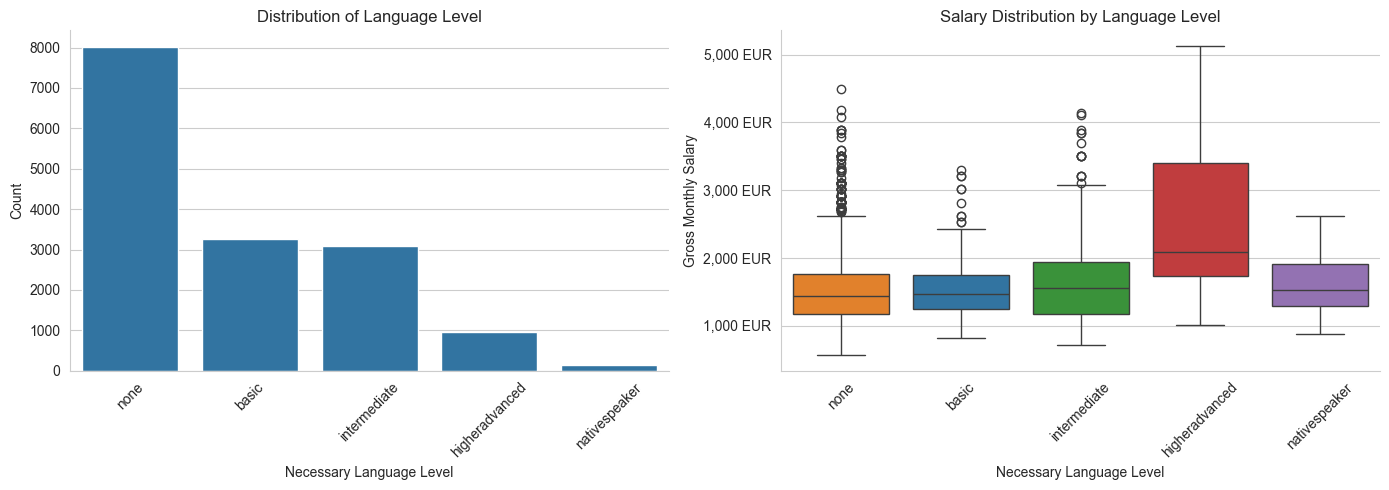

In [64]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), facecolor="White")

order=["none", 'basic', 'intermediate', 'higheradvanced', 'nativespeaker']

# First subplot: Countplot
# (sns.histplot don't support ordering labels so we have to use sns.countplot)
sns.countplot(
    data=df_jobs_clean,
    x="language_level",
    order=order,
    ax=axes[0]
)

axes[0].set_facecolor("White")
axes[0].set_xlabel("Necessary Language Level")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Language Level")
axes[0].tick_params(axis='x', rotation=45)

# Remove right and top spines from first subplot
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Second subplot: Boxplot
sns.boxplot(
    data=df_jobs_clean,
    x="language_level",
    order=order,
    y="gross_monthly_salary EUR",
    hue="language_level",
    ax=axes[1]
)


# Format y-axis ticks to show EUR currency
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,} EUR')

axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_facecolor("White")
axes[1].set_xlabel("Necessary Language Level")
axes[1].set_ylabel("Gross Monthly Salary")
axes[1].set_title("Salary Distribution by Language Level")
axes[1].tick_params(axis='x', rotation=45)

# Remove right and top spines from second subplot
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

# Adjust layout
plt.tight_layout()

This visualization shows how language skills affect job offers and salaries. The left chart displays the number of job offers by required language level. Most offers do not require any language skills, followed by basic and intermediate levels. Advanced and mother tongue levels are less common, meaning fewer jobs ask for high language proficiency. This suggests that many jobs are open to people with low or no language skills.

The right chart shows salary distribution for each language level. It uses box plots to show the median, range, and outliers of monthly salaries. Jobs that require advanced or mother tongue language skills offer higher median salaries. This means better language skills can lead to better pay. In conclusion, while most jobs do not demand strong language skills, improving language proficiency may help people earn more.

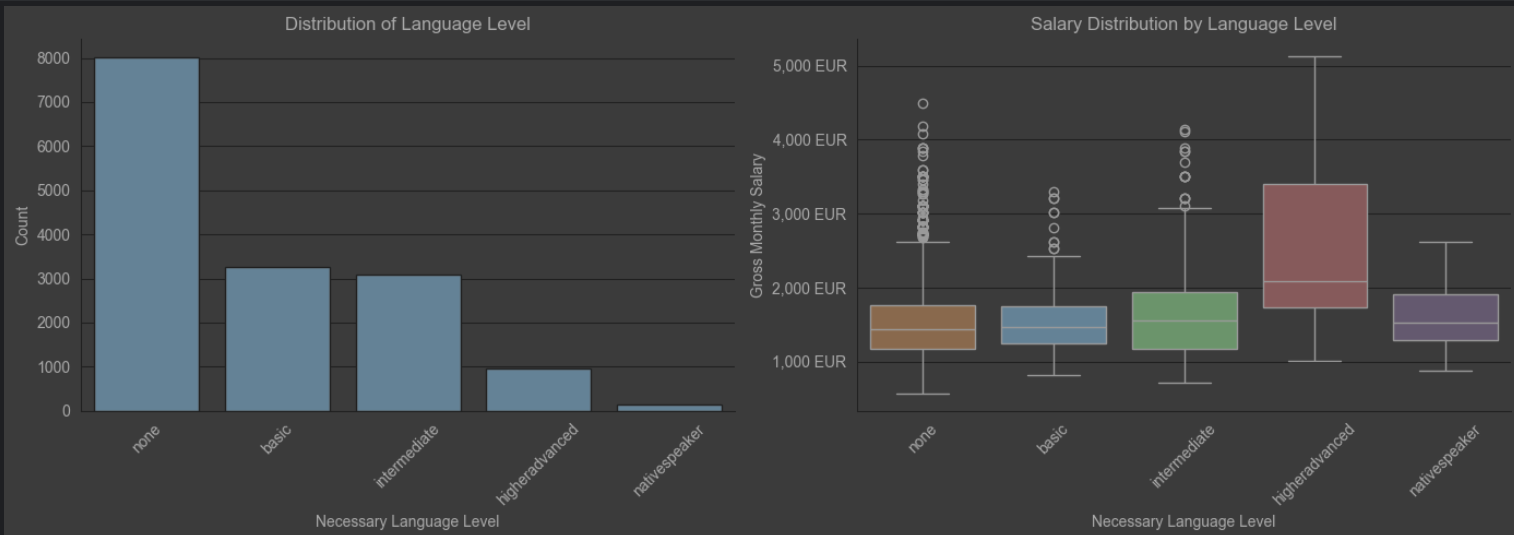

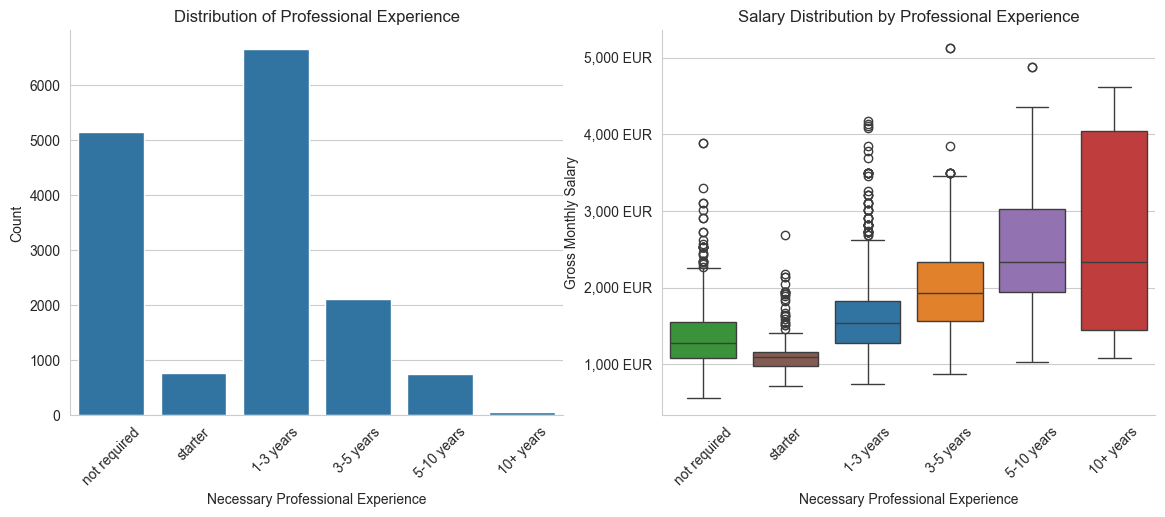

In [66]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

order = ['not required', 'starter', '1-3 years', '3-5 years', '5-10 years', '10+ years']

# First subplot: Countplot
# sns.histplot don't support ordering labels so we have to use sns.countplot
sns.countplot(
    data=df_jobs_clean,
    x="expected_experience",
    order=order,
    ax=axes[0]
)

axes[0].set_xlabel("Necessary Professional Experience")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Professional Experience")
axes[0].tick_params(axis='x', rotation=45)

# Remove right and top spines from first subplot
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Second subplot: Boxplot
sns.boxplot(
    data=df_jobs_clean,
    x="expected_experience",
    order=order,
    y="gross_monthly_salary EUR",
    hue="expected_experience",
    ax=axes[1]
)

# Format y-axis ticks to show EUR currency
formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x):,} EUR')

axes[1].yaxis.set_major_formatter(formatter)
axes[1].set_xlabel("Necessary Professional Experience")
axes[1].set_ylabel("Gross Monthly Salary")
axes[1].set_title("Salary Distribution by Professional Experience")
axes[1].tick_params(axis='x', rotation=45)

# Remove right and top spines from second subplot
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

This visualization explores how professional experience influences job availability and salary levels on a job advertising platform. The left chart shows that most job offers target candidates with less than 3 years of experience, followed by starter-level roles and those requiring 3–5 years. Offers for highly experienced professionals (10+ years) are the least common, suggesting that entry-level and junior positions dominate the platform. This may reflect broader hiring trends or a focus on scalable, trainable talent.

The right chart uses box plots to show salary distribution across experience levels. Median salaries increase steadily with more experience, peaking in the 10+ years category. The interquartile ranges also widen with seniority, indicating greater variability and earning potential at higher levels. Notably, even roles with no experience required offer competitive salaries, though they remain lower than those for seasoned professionals. Together, these charts highlight a clear trade-off: while junior roles are more abundant, senior roles offer significantly higher compensation. This insight can help job seekers align their expectations and career planning with market realities.
